__mlmachine - Part 2: Pandas In / Pandas Out Pipelines__

1. [Transformers, Now with DataFrames](#Transformers,-Now-with-DataFrames)
    1. [Scikit-learn Dismantles Pandas DataFrames](#Scikit-learn-Dismantles-Pandas-DataFrames)
1. [PandasFeatureUnion & DataFrameSelector - Intuitive, Familiar, Flexible](#PandasFeatureUnion-&-DataFrameSelector-Intuitive,-Familiar,-Flexible)
    1. [Vanilla FeatureUnion](#Vanilla-FeatureUnion)
    1. [PandasFeatureUnion & DataFrameSelector](#PandasFeatureUnion-&-DataFrameSelector)
        1. [Basic Example](#Basic-Example)
        1. [Less Basic Example](#Less-Basic-Example)

In [1]:
# standard libary and settings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
import mlmachine as mlm
from mlmachine.data import titanic
from mlmachine.features.preprocessing import DataFrameSelector, PandasTransformer, PandasFeatureUnion

c:\users\petersont\appdata\local\continuum\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


---
# Transformers, Now with DataFrames
---

<a id = 'Transformers,-Now-with-DataFrames'></a>

---
## Scikit-learn Dismantles Pandas DataFrames
---
<br><br>
A major drawback of putting a `DataFrame` through an Scikit-learn transformer is the loss of the `DataFrame` wrapper around the underlying NumPy array. The issue is particularly pronounced with transformers like `PolynomialFeatures`:

<br><br>
![alt text](images/p2_pandastransformer.jpeg "EDA Panel")
<br><br>
And if we think we've outsmarted this transformer by accessing the `poly.get_feature_names()` attribute, we'll be woefully disappointed once we see the output:
<br><br>
![alt text](images/p2_features.jpeg "EDA Panel")
<br><br>
Not helpful.
<br><br>

Due to this, we lose the ability to:
- Easily perform EDA on the transformed dataset
- Evaluate feature importance after training a model
- Use model explainability methods such as SHAP or LIME
- Merely identity which columns are which
<br><br>
Of course we could feed the NumPy array back into a `DataFrame`, and do whatever is needed to get the columns to match up, but…what a chore.
mlmachine leverages a class called `PandasTransformer` to ensure that if a `DataFrame` passes into a transformer, a `DataFrame` comes out on the other side:
<br><br>
![alt text](images/p2_pandastransformer_2.jpeg "EDA Panel")
<br><br>

All we had to do was wrap `PolynomialFeatures` with `PandasTransformer` and we get a `DataFrame` with meaningful column names.

Now that we've seen how to preserve our `DataFrame` when executing a single transformation, let's build on this with Scikit-learn's `Pipeline` and `FeatureUnion` functionality to perform multiple actions on multiple sets of features in one shot.
<br><br>



<a id = 'Scikit-learn-Dismantles-Pandas-DataFrames'></a>

---
# PandasFeatureUnion & DataFrameSelector - Intuitive, Familiar, Flexible
---

<a id = 'PandasFeatureUnion-&-DataFrameSelector-Intuitive,-Familiar,-Flexible'></a>

---
## Vanilla FeatureUnion
---
<br><br>
Scikit-learn includes a class called `FeatureUnion`. To quote the documentation, `FeatureUnion` "Concatenates results of multiple transformer objects…This is useful to combine several feature extraction mechanisms into a single transformer."
<br><br>

This is a great tool for applying different data processing actions to different features. For example, we may want to mean impute continuous features and mode impute categorical features:
<br><br>

<br><br>
![alt text](images/p2_featureunion.jpeg "EDA Panel")
<br><br>
Unfortunately, `FeatureUnion` also suffers from the same disadvantage as other transformers - it returns a NumPy array. This is where `PandasFeatureUnion` comes to the rescue.
<br><br>

<a id = 'Vanilla-FeatureUnion'></a>

---
## PandasFeatureUnion & DataFrameSelector
---
<br><br>
Just like we need `PandasTransformer` to retain the `DataFrame` post-transformation, we need `PandasFeatureUnion` to maintain the final concatenated `DataFrame`.
<br><br>


<a id = 'PandasFeatureUnion-&-DataFrameSelector'></a>

---
### Basic Example
---
<br><br>
We begin by instantiating a `Machine` object called `mlmachine_titanic`. Then we use mlmachine's `PandasFeatureUnion` class to create a `DataFrame`-friendly, union-style pipeline. Specifically, we perform three different types of imputations on three different columns.
- Impute "Age" with the mean
- Impute "Embarked" with the mode
- Impute "Cabin" with a constant value (X).
<br><br>

A keen observer will notice the presence of another class - `DataFrameSelector` - within each pipeline. This class is an essential element of the `PandasFeatureUnion` workflow, and serves different purposes depending on where it appears in the pipeline. On lines 27, 31 and 35, `DataFrameSelector` is used to select the column for that particular branch of the union. The columns are selected by name using the `include_columns` parameter.
<br><br>

On line 39, we do something a bit different. Since `FeatureUnion` operations, by design, act on specific columns and concatenate the results, we would be left with only the transformed columns without further intervention.
<br><br>

That is why `DataFrameSelector` has the flexibility to select all columns except those specified. By way of the `exclude_columns` parameter, we select all features except for the features we imputed. This ensures we keep our full dataset.
<br><br>

Now that we have filled in our nulls values, let's conclude this part of the series with a slightly more complicated preprocessing step  using the `PandasFeatureUnion` workflow.

<a id = 'Basic-Example'></a>

In [2]:
df_train, df_valid = titanic()

mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked","Cabin"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = {"Pclass": [1, 2, 3]},
    is_classification=True,
)

# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Embarked","Cabin"])
    )),
])

mlmachine_titanic.data = impute_pipe.fit_transform(mlmachine_titanic.data)

>>> category label encoding

	0 --> 0
	1 --> 1



---
### Less Basic Example
---
<br><br>
Let's take this branch by branch:
- "nominal" pipeline - Here we see the flexibility of `DataFrameSelector`. First, we select all nominal columns using the `include_mlm_dtypes` parameter. Second, we exclude "Cabin" (also a nominal feature) by passing the feature name to the `exclude_columns` parameter. `DataFrameSelector` reconciles our include/exclude specifications by selecting all nominal columns except "Cabin". Lastly, we pass our selected columns to OneHotEncoder, wrapped in `PandasTransformer`. 
<br><br>


- "ordinal" pipeline - We again us the `DataFrameSelector` parameter `include_mlm_dtypes`, this time to select all ordinal columns. Then we pass our result to `OrdinalEncoder`, wrapped in `PandasTransformer`. We also provide encoding instructions. When we instantiated our `Machine` object, we passed in a dictionary called `ordinal_encodings`, which `mlmachine_titanic` stores as an attribute. We wrap this dictionary's values in a list and pass it to the `OrdinalEncoder` parameter `categories`. This will ensure the desired order is enforced during ordinal encoding.
<br><br>

- "bin" pipeline - We use `include_mlm_dtypes` to select all continuous features and pass the result to `KBinsDiscretizer`, wrapped in `PandasTransformer`. 
<br><br>

- "diff" pipeline - The last step is to recombine any features that would otherwise be lost in the union operation, and drop any features we no longer need. We perform a list comprehension on the `mlm_dtypes` attribute to remove "Cabin", and append the keys of `mlmachine_titanic.ordinal_encodings` to the result. This will ensure that the original nominal and ordinal features are not in the transformed dataset. Notice that we do not exclude the continuous columns, despite the fact we transformed these features with `KBinsDiscretizer`. The reason is simple - we want to keep the original continuous columns in our dataset.
<br><br>

<a id = 'Less-Basic-Example'></a>

In [3]:
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(
            include_mlm_dtypes=["nominal"],
            exclude_columns=["Cabin"]
        ),
        PandasTransformer(OneHotEncoder())
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["ordinal"]),
        PandasTransformer(
            OrdinalEncoder(categories=list(mlmachine_titanic.ordinal_encodings.values()))
        )
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(
            exclude_columns=[i for i in mlmachine_titanic.data.mlm_dtypes["nominal"] if i != "Cabin"]\
            + list(mlmachine_titanic.ordinal_encodings.keys())
        )
    )),
])

mlmachine_titanic.data = encode_pipe.fit_transform(mlmachine_titanic.data)
mlmachine_titanic.update_dtypes()

---
<br><br>
Finally, we follow the fit-transform with a call of the `update_mlm_dtypes()` method. Let see what our updated `mlm_dtypes` dictionary looks like now:
<br><br>

In [4]:
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Sex_female',
  'Sex_male'],
 'ordinal': ['Age_binned_5', 'Fare_binned_5', 'Pclass_ordinal_encoded'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Age_binned_5',
  'Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Fare_binned_5',
  'Pclass_ordinal_encoded',
  'Sex_female',
  'Sex_male'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

---
<br><br>
All seems to be in order. The "nominal" key includes dummy columns for the features "Embarked" and "Sex", and still contains the "Cabin" feature, which we chose to leave untouched at this point. The "ordinal" key contains our binned versions of "Age" and "Fare", as well as "Pclass" which has been named in a way that clearly indicates the type of encoding applied. Now we can leverage mlm_dtypes attribute to quickly perform additional preprocessing steps or EDA on our new features. 
<br><br>

Let's generate an EDA panel for all three "ordinal" features:
<br><br>

Feature summary,Feature vs. target summary,Target proportion
Age_binned_5,Count,Proportion
2,267,29.966330
3,189,21.212121
4,188,21.099888
0,164,18.406285
1,83,9.315376
Age_binned_5,Died,Survived
0,85,79
1,59,24
2,177,90


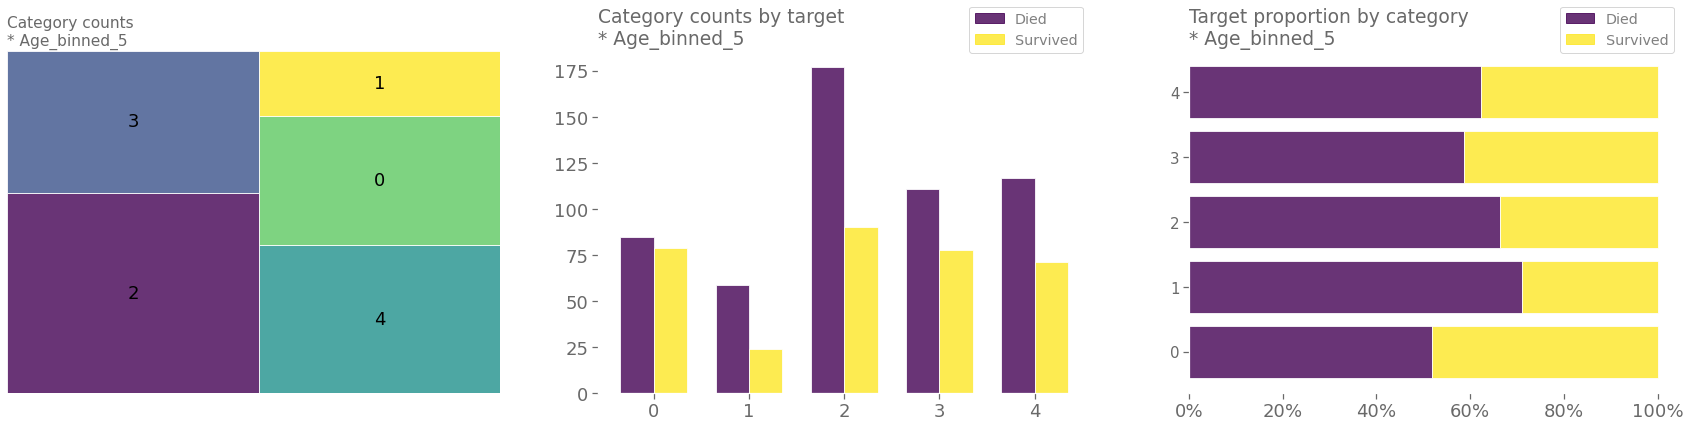

Feature summary,Feature vs. target summary,Target proportion
Fare_binned_5,Count,Proportion
2,195,21.885522
4,182,20.426487
3,175,19.640853
1,173,19.416386
0,166,18.630752
Fare_binned_5,Died,Survived
0,130,36
1,142,31
2,113,82


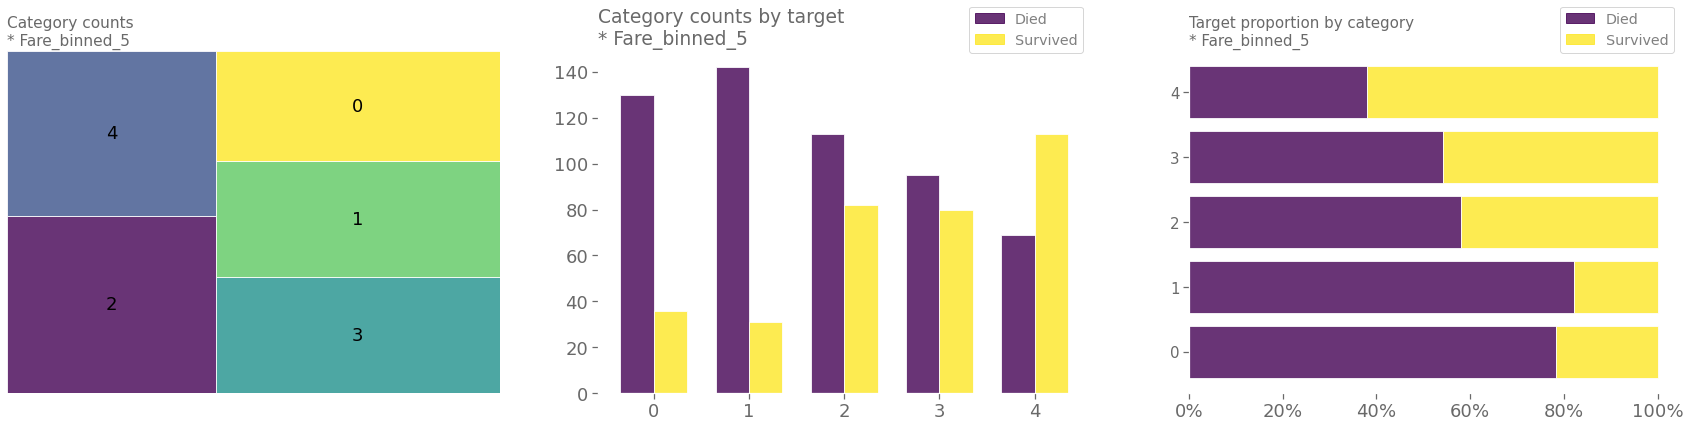

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass_ordinal_encoded 
 Count 
 Proportion 
 
 
 
 
 2 
 491 
 55.106622 
 
 
 0 
 216 
 24.242424 
 
 
 1 
 184 
 20.650954 
 
 
 
 
 
 Pclass_ordinal_encoded 
 Died 
 Survived 
 
 
 
 
 0 
 80 
 136 
 
 
 1 
 97 
 87 
 
 
 2 
 372 
 119 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

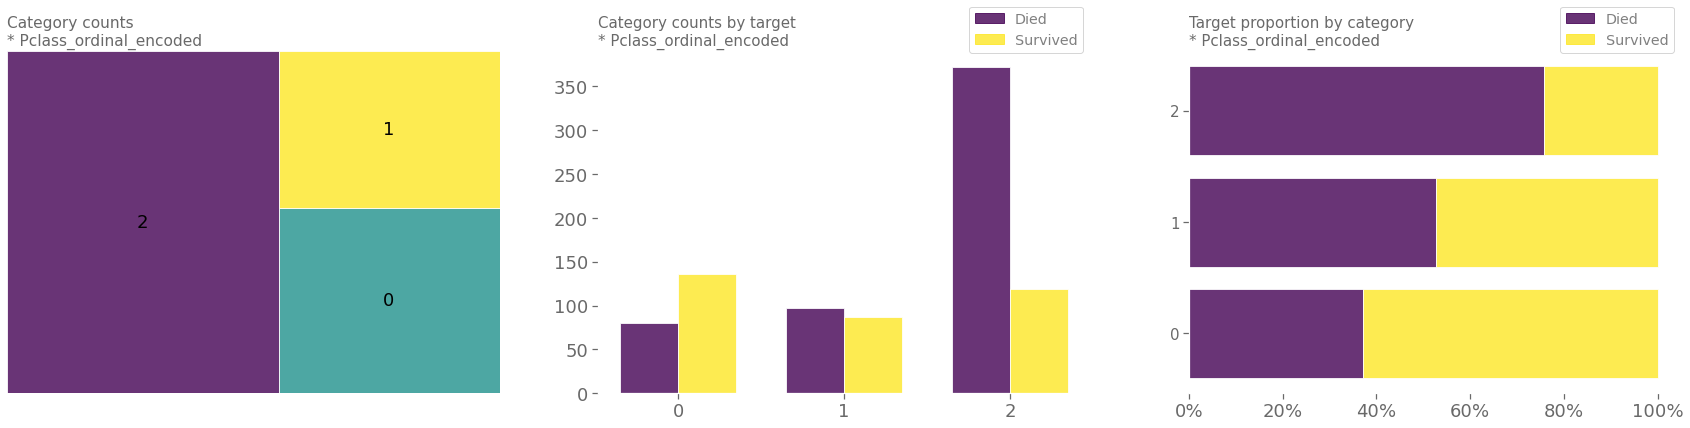

In [5]:
for feature in mlmachine_titanic.data.mlm_dtypes["ordinal"]:
    mlmachine_titanic.eda_cat_target_cat_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
    )